# Fashion-MNIST dataset

Fashion-MNIST is a dataset of Zalando's images, it consists of a training set with 60,000 images and a test set of 10,000 images. Each example is a 28x28 grayscale image and is laballed as one out of 10 different classes. We will use this dataset to develop a Multilayer Perceptron (MLP) and a Convolutional Neural Network (CNN) for image classification.

Both a MLP and a CNN can be used for image classification, however MLP takes vectors as input, while CNN takes tensors as input. CNNs are now the go-to method to address a prediction problem with image data as input. The strength of CNNs is that input tensors allow to grasp the spatial relation between pixels of images, therefore for complicated images it will outperform MLP. 

The goal of this project is to understand if the Fashion-MNIST dataset is simple enough that it can be handled with a MLP, or whether it requires a CNN to reach a satisfying classification performance.

#Load and inspect the dataset

First of all, we will load the Fashion-MNIST dataset from Keras, split it into train and test sets, check that the dimensions of each set are as expected and if there are any missing data.

In [ ]:
from keras.datasets import fashion_mnist          # import the dataset

# import the libraries needed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
# split the data into train set and test set
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('\n')
 
# check the dimension of each set
print('Fashion-MNIST dataset dimensions:')
print('X train: ', X_train.shape)
print('X test: ', X_test.shape)
print('Y train: ', y_train.shape)
print('Y test: ', y_test.shape)

4422102/4422102 [==============================] - 0s 0us/step


Fashion-MNIST dataset dimensions:
X train:  (60000, 28, 28)
X test:  (10000, 28, 28)
Y train:  (60000,)
Y test:  (10000,)


In [ ]:
# check if there are null values
print('NaN in X_train:', np.isnan(X_train).sum())
print('NaN in X_test:',np.isnan(X_test).sum())
print('NaN in y_train:',np.isnan(y_train).sum())
print('NaN in y_test:',np.isnan(y_test).sum())

NaN in X_train: 0
NaN in X_test: 0
NaN in y_train: 0
NaN in y_test: 0


The X variables are the examples: as described above, there are 60k training images and 10k testing images, where each image is 28 pixels in height and 28 pixels in width. The Y variables are the labels. The model will learn how to perform image classification using the training set and will be evaluated on the testing set.



In [ ]:
# possible values for the labels
print('Unique labels: ',np.unique(y_train))

Unique labels:  [0 1 2 3 4 5 6 7 8 9]


As anticipated, there are 10 different labels, each corresponding to a class of clothing:
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

In [ ]:
# store the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
# check class balance
label_count_tr = np.bincount(y_train)
label_count_test = np.bincount(y_test)

print('Class balance in TRAINING set')
for i in range(10):
  print("{:<15s}:   {}".format(class_names[i], label_count_tr[i]))

print('\n')
print('Class balance in TEST set')
for i in range(10):
    print("{:<15s}:   {}".format(class_names[i], label_count_test[i]))

Class balance in TRAINING set
T-shirt/top    :   6000
Trouser        :   6000
Pullover       :   6000
Dress          :   6000
Coat           :   6000
Sandal         :   6000
Shirt          :   6000
Sneaker        :   6000
Bag            :   6000
Ankle boot     :   6000


Class balance in TEST set
T-shirt/top    :   1000
Trouser        :   1000
Pullover       :   1000
Dress          :   1000
Coat           :   1000
Sandal         :   1000
Shirt          :   1000
Sneaker        :   1000
Bag            :   1000
Ankle boot     :   1000


A balanced dataset contains equal (or almost equal) number of samples for each class. Data balacing plays a key role in the accuracy of the model. As we can see in our dataset the classes are perfectly balanced: as there are exactly 6000 and 1000 examples for each clothing item in the training and test set respectively.

The data balance and the absence of missing data makes the Fashion-MNIST dataset of high quality.

Let's now take a look at the first example in the training dataset to understand what we are working with.

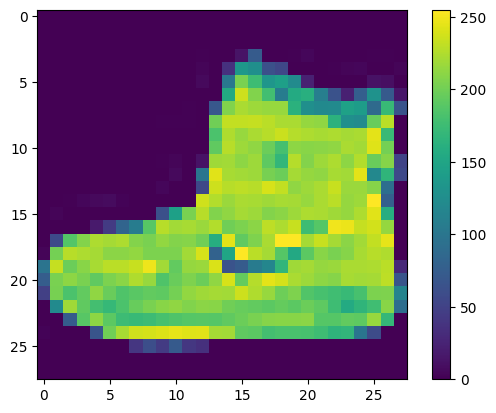

In [ ]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

Next, let's visualize different types of clothing images, along with their label.

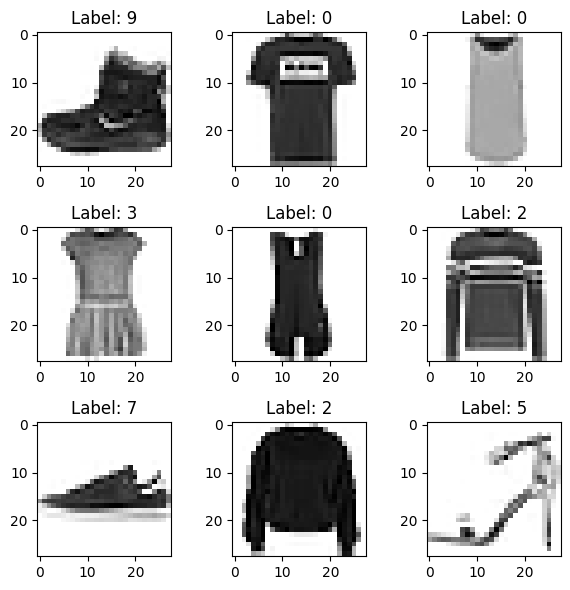

In [ ]:
# show 3x3 images
num_row = 3
num_col = 3

# slice the dataset
num = num_row*num_col
images = X_train[:num]
labels = y_train[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap=plt.cm.binary)
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

Now that we have explored and gotten to know our dataset we can move on to perform some preprocessing before feeding it to our models. 

# Data preprocessing

## Encoding the labels

The Fashion-MNIST dataset has 10 classes (0 1 2 3 4 5 6 7 8 9). Let's one-hot encode each of them using the **to_categorical()** function, which converts a class into a binary matrix.

In [ ]:
# one-hot encoding (OHE) the labels
y_train_OHE = to_categorical(y_train, num_classes=10)
y_test_OHE = to_categorical(y_test, num_classes=10)

In [ ]:
# visualize the label of the 1st training example before and after OHE
print('Before OHE: ', y_train[0])
print('After OHE: ', y_train_OHE[0])

Before OHE:  9
After OHE:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Rescale data

In colored images, each pixel can be represented by a vector of three numbers (each ranging from 0 to 255) for the three primary color channels: red, green and blue (RGB). These three RGB values are used together to decide the color of that pixel. 

As we can see below, the images have intensity between 0 and 255. However, for our model to work properly, it is best to rescale the pixel values to the range [0,1]. We can easily do it by dividing all the intensities by 255.

In [ ]:
# check min and max pixel intensity
print('Min: %s - Max: %s' % (X_train.min() , X_train.max()))

Min: 0 - Max: 255


In [ ]:
# rescale pixels intensity to [0,1] range
X_train, X_test = X_train/255.0, X_test/255.0

In [ ]:
# check that rescaling worked properly
print('Min: %s - Max: %s' % (X_train.min() , X_train.max()))

Min: 0.0 - Max: 1.0


# Multilayer Perceptron (MLP)

As we know, NNs take one-dimensional data as input. Let's check again the dimension of our training examples to see if we need to reshape it:

In [ ]:
print('X train: ', X_train.shape)
print('X test: ', X_test.shape)

X train:  (60000, 28, 28)
X test:  (10000, 28, 28)


From the train shape we see that we have (60000, 28, 28), where 60000 is the number of records and each record is 28x28, so each example is 2D. The same reasoning applies to the test set. In order to feed 1D data to the NN we need to reshape the 2D-array of 28x28 pixels to a 1D-array of 784 pixels (28*28): we will achieve this goal using a Flatten layer.

## Simple 3-layer NN 

The first step is to build the model, to do so we will use the **Sequential()** function, that allows to stack layers on top of each other.
Let's start with a simple 3-layer NN: 
1. **input** Flatten layer - will flatten the input data from 2D to 1D
2. **hidden** Dense layer - fully connected layer with 128 neurons and *ReLu* as activation function
3. **output** Dense layer - fully connected layer with 10 neurons (one for each class) and *softmax* activation function, which converts the vector it receives from the final hidden layer into a probability distribution that sums to 1

In [ ]:
# build the model
model_3 = keras.Sequential()
model_3.add(keras.layers.Flatten(input_shape=(28, 28)))           # reshaping layer
model_3.add(keras.layers.Dense(128, activation='relu'))
model_3.add(keras.layers.Dense(10, activation='softmax'))

This is the NN's architecture:

In [ ]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Now that the NN's scaffold is ready we can compile it by setting the type of loss function, optimizer and evaluation metrics to use:
- **loss function** - it measures how accurate the model is during the training by calculating the difference between the output and the target variable: so we want to minimze this function. As we are dealing with a multi-class classification task we will use **categorical crossentropy** as loss function
- **optimizer** - it changes the attributes of the NN, such as the weights and the learning rate. We will use **Adam** which is an extension of the classic stochastic gradient descent (SGD) but unlike SGD, that maintains a single learning rate through training, Adam updates the learning rate for each network weight individually
- **metrics** - to evaluate the performance of our model. We will use **accuracy**, which is the ratio of correct predictions over the total number of input samples

In [ ]:
# compiling the model
model_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])

It is now time to train the model.

In [ ]:
# train the model

%%time
history_3NN = model_3.fit(X_train, y_train_OHE, epochs=5, validation_split=0.33)

Epoch 1/5
1257/1257 [==============================] - 11s 5ms/step - loss: 0.5350 - accuracy: 0.8114 - val_loss: 0.4301 - val_accuracy: 0.8482
Epoch 2/5
1257/1257 [==============================] - 5s 4ms/step - loss: 0.4009 - accuracy: 0.8567 - val_loss: 0.3835 - val_accuracy: 0.8614
Epoch 3/5
1257/1257 [==============================] - 5s 4ms/step - loss: 0.3592 - accuracy: 0.8684 - val_loss: 0.3849 - val_accuracy: 0.8635
Epoch 4/5
1257/1257 [==============================] - 5s 4ms/step - loss: 0.3324 - accuracy: 0.8786 - val_loss: 0.3425 - val_accuracy: 0.8756
Epoch 5/5
1257/1257 [==============================] - 5s 4ms/step - loss: 0.3140 - accuracy: 0.8845 - val_loss: 0.3586 - val_accuracy: 0.8675
CPU times: user 29.5 s, sys: 3.62 s, total: 33.1 s
Wall time: 41.9 s


As we can see, at each epoch the loss decreases and accuracy increases, so our model is improving. We can also visualize the learning curve of the model.

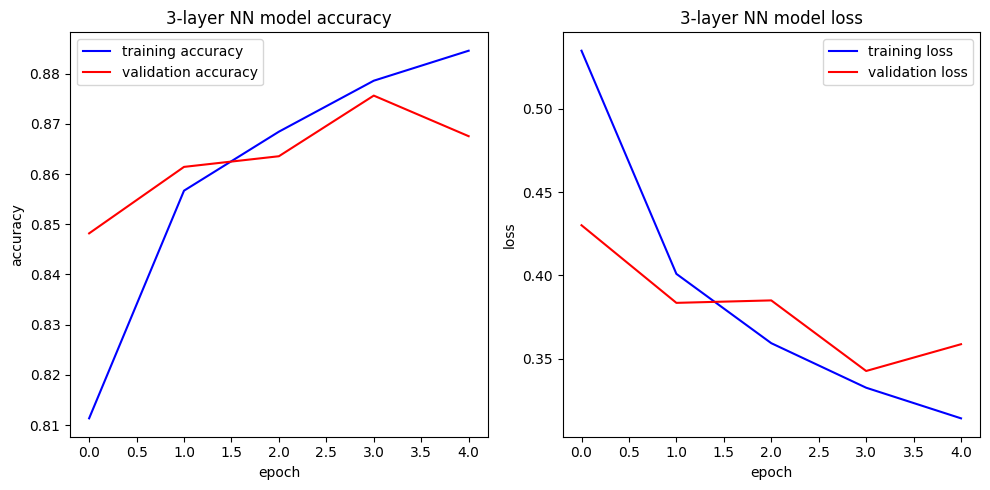

In [ ]:
# plot the learning curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_3NN.history['accuracy'], 'blue')
plt.plot(history_3NN.history['val_accuracy'], 'red')
plt.title('3-layer NN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy','validation accuracy'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_3NN.history['loss'], 'blue')
plt.plot(history_3NN.history['val_loss'], 'red')
plt.title('3-layer NN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss','validation loss'], loc='upper right')

plt.tight_layout()

We have set up and trained the model, now we can evaluate its performance in predicting the unseen test set. We will start with predicting the first example in the train set.

In [ ]:
# predict the 1st image in the test set
pred_0 = model_3.predict(X_test)[0]
print(pred_0)

313/313 [==============================] - 0s 1ms/step
[9.3218378e-06 1.2758268e-07 7.0548085e-06 3.3515676e-07 5.3809608e-06
 3.3948224e-02 3.2752061e-05 1.4540586e-02 1.0899356e-04 9.5134723e-01]


How do we interpret this prediction? We used **Softmax** as activation function which does not compute the *prediction* itself but rather a discrete probability distribution over the target classes. So basically these 10 numbers represent the probability that the input example belongs to each class. As we can see the highest number is the last one, meaning that the input image has the highest probability to belong to this class (Ankle boot).

In [ ]:
# retrieve the max probability and its index in the list of labels (class_names)
prob, id = pred_0.max(), list(pred_0).index(pred_0.max())     
print('Highest probability: %s - predicted class: %s ' %(prob, class_names[id]))

Highest probability: 0.95134723 - predicted class: Ankle boot 


Real class:  Ankle boot


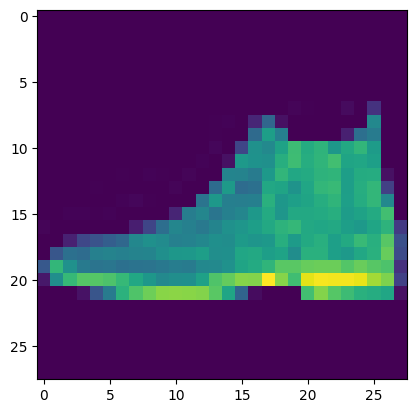

In [ ]:
plt.imshow(X_test[0])
print('Real class: ', class_names[y_test[0]])

The model works! It predicted that the first example in the test set is an ankle boot and indeed it is. Now we move on to using the model to predict the classes of the entire test set and see how it performs.

In [ ]:
# evaluate the model
test_loss, test_acc = model_3.evaluate(X_test, y_test_OHE)

313/313 [==============================] - 1s 3ms/step - loss: 0.3897 - accuracy: 0.8597


In [ ]:
print('Model: 3-layer NN - loss on the test set: ',round(test_loss*100,4),'%')
print('Model: 3-layer NN - accuracy on the test set: ',round(test_acc*100,4),'%')

Model: 3-layer NN - loss on the test set:  38.9737 %
Model: 3-layer NN - accuracy on the test set:  85.97 %


Our 3-layer NN achieved a loss around 39% and accuracy around 86% on the test set, which is a bit worse than the values of loss and accuracy at the last epoch but they are close enough.
Let's display the model's confusion matrix to understand more about the predictions.

313/313 [==============================] - 1s 2ms/step


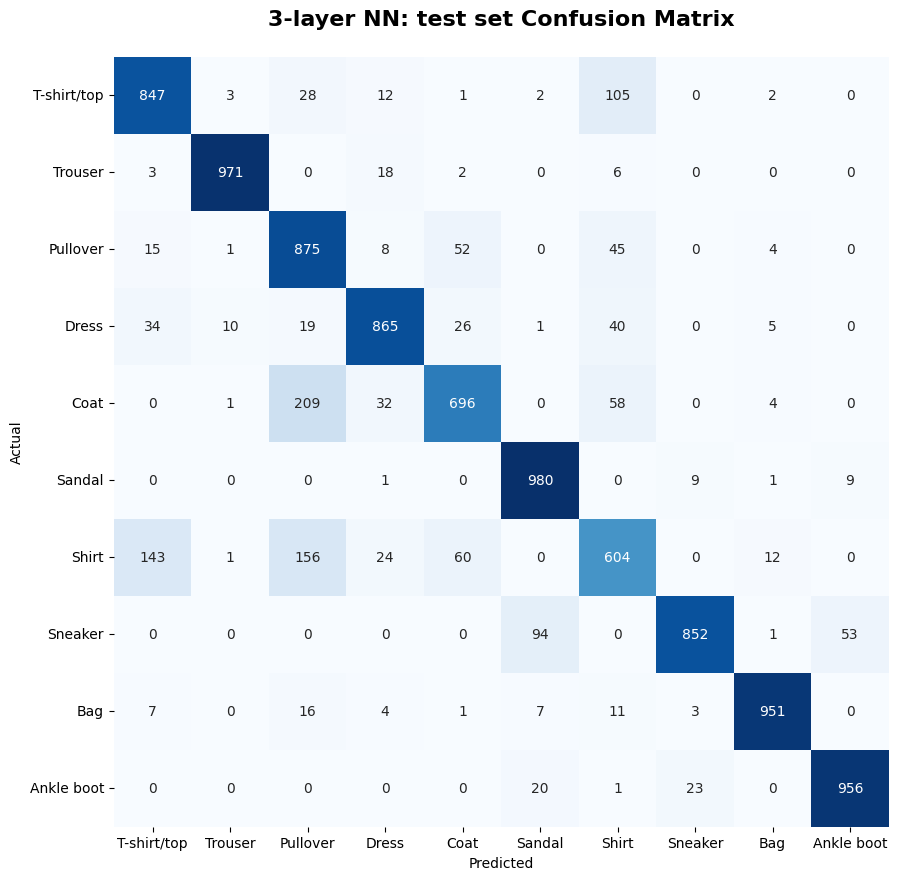

In [ ]:
# predict the test set and compare the predictions with the real classes
y_pred = model_3.predict(X_test)                 # predict test set
y_pred_CM = np.argmax(y_pred, axis=1)            # get the index of the max value in the prediction vector (so the most probable class) for each example predicted
y_test_CM = np.argmax(y_test_OHE, axis=1)        # get the index of the max value in the encoded vector with the real classes (so the real class) for each example

# compute and diplay the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test_CM, y_pred_CM), annot=True, cbar=False, fmt='1d', cmap='Blues', ax=ax)
ax.set_title('3-layer NN: test set Confusion Matrix\n', fontweight='bold', fontsize=16)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names, rotation=0)
plt.show()

As we can see most values are on the diagonal, meaning that most examples are correctly classified.

 We can notice that the *Shirt* class is the most problematic one, as it is often confused for other outwear items such as *T-shirt/top*, *Pullover*, *Dress*, *Coat* and sometimes for *Bag*. Also footwear items such as *Sandal*, *Sneaker* and *Ankle boot* are sometimes confused for each other.

Let's see if a deeper NN is more accurate.

## Deeper 6-layer NN

As we just observed, a simple 3-layer NN achieved a test loss of 39% and a test accuracy of 86%. Let's see if a NN with more hidden layers is able to do better.

In [ ]:
# build the model
model_6 = keras.Sequential()
model_6.add(keras.layers.Flatten(input_shape=(28, 28)))           # reshaping layer
model_6.add(keras.layers.Dense(128, activation='relu'))
model_6.add(keras.layers.Dense(128, activation='relu'))           # additional hidden layer
model_6.add(keras.layers.Dense(128, activation='relu'))           # additional hidden layer
model_6.add(keras.layers.Dense(128, activation='relu'))           # additional hidden layer
model_6.add(keras.layers.Dense(10, activation='softmax'))

# architecture of the model
model_6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 151,306
Trainable params: 151,306
Non-tr

In [ ]:
# compile the model
model_6.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])

# train the model
history_6NN = model_6.fit(X_train, y_train_OHE, epochs=5, validation_split=0.33)

Epoch 1/5
1257/1257 [==============================] - 8s 5ms/step - loss: 0.5302 - accuracy: 0.8081 - val_loss: 0.4141 - val_accuracy: 0.8460
Epoch 2/5
1257/1257 [==============================] - 6s 5ms/step - loss: 0.3882 - accuracy: 0.8570 - val_loss: 0.4326 - val_accuracy: 0.8396
Epoch 3/5
1257/1257 [==============================] - 6s 4ms/step - loss: 0.3548 - accuracy: 0.8698 - val_loss: 0.3630 - val_accuracy: 0.8678
Epoch 4/5
1257/1257 [==============================] - 6s 5ms/step - loss: 0.3317 - accuracy: 0.8764 - val_loss: 0.3499 - val_accuracy: 0.8716
Epoch 5/5
1257/1257 [==============================] - 6s 5ms/step - loss: 0.3129 - accuracy: 0.8833 - val_loss: 0.3308 - val_accuracy: 0.8810


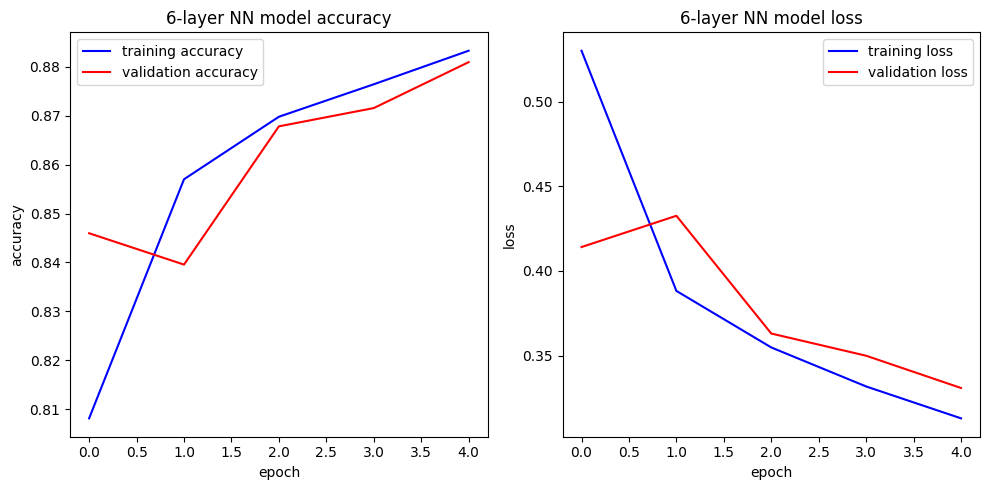

In [ ]:
# plot the learning curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_6NN.history['accuracy'], 'blue')
plt.plot(history_6NN.history['val_accuracy'], 'red')
plt.title('6-layer NN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_6NN.history['loss'], 'blue')
plt.plot(history_6NN.history['val_loss'], 'red')
plt.title('6-layer NN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss','validation loss'], loc='upper right')

plt.tight_layout()

In [ ]:
# evaluate the model
test_loss, test_acc = model_6.evaluate(X_test, y_test_OHE)

313/313 [==============================] - 1s 3ms/step - loss: 0.3594 - accuracy: 0.8723


In [ ]:
print('Model: 6-layer NN - test loss: ',round(test_loss*100,4),'%')
print('Model: 6-layer NN - test accuracy: ',round(test_acc*100,4),'%')

Model: 6-layer NN - test loss:  35.9438 %
Model: 6-layer NN - test accuracy:  87.23 %


The 6-layer NN obtained a test loss around 36% and test accuracy around 87%, so it performed slightly better than the 3-layer NN (test loss: 39% and test accuracy: 86%). Lastly, let's see the image classification performance of a NN with even more hidden layers.



## Even deeper 12-layer NN

Lastly, we can try an even deeper 12-layer NN and compare its performance to the previous NNs.

In [ ]:
# build the model
model_12 = keras.Sequential()
model_12.add(keras.layers.Flatten(input_shape=(28, 28)))           # reshaping layer
model_12.add(keras.layers.Dense(128, activation='relu'))
model_12.add(keras.layers.Dense(128, activation='relu'))
model_12.add(keras.layers.Dense(128, activation='relu'))
model_12.add(keras.layers.Dense(128, activation='relu'))
model_12.add(keras.layers.Dense(128, activation='relu'))           # additional hidden layer
model_12.add(keras.layers.Dense(128, activation='relu'))           # additional hidden layer
model_12.add(keras.layers.Dense(128, activation='relu'))           # additional hidden layer
model_12.add(keras.layers.Dense(128, activation='relu'))           # additional hidden layer
model_12.add(keras.layers.Dense(128, activation='relu'))           # additional hidden layer
model_12.add(keras.layers.Dense(128, activation='relu'))           # additional hidden layer
model_12.add(keras.layers.Dense(10, activation='softmax'))

# architecture of the model
model_12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               100480    
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)              

In [ ]:
# compile the model
model_12.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])

# train the model
history_12NN = model_12.fit(X_train, y_train_OHE, epochs=5, validation_split=0.33)

Epoch 1/5
1257/1257 [==============================] - 12s 7ms/step - loss: 0.6383 - accuracy: 0.7630 - val_loss: 0.4797 - val_accuracy: 0.8284
Epoch 2/5
1257/1257 [==============================] - 10s 8ms/step - loss: 0.4477 - accuracy: 0.8406 - val_loss: 0.4304 - val_accuracy: 0.8524
Epoch 3/5
1257/1257 [==============================] - 8s 6ms/step - loss: 0.4058 - accuracy: 0.8556 - val_loss: 0.3927 - val_accuracy: 0.8596
Epoch 4/5
1257/1257 [==============================] - 8s 6ms/step - loss: 0.3805 - accuracy: 0.8650 - val_loss: 0.3952 - val_accuracy: 0.8653
Epoch 5/5
1257/1257 [==============================] - 9s 7ms/step - loss: 0.3620 - accuracy: 0.8707 - val_loss: 0.4327 - val_accuracy: 0.8480


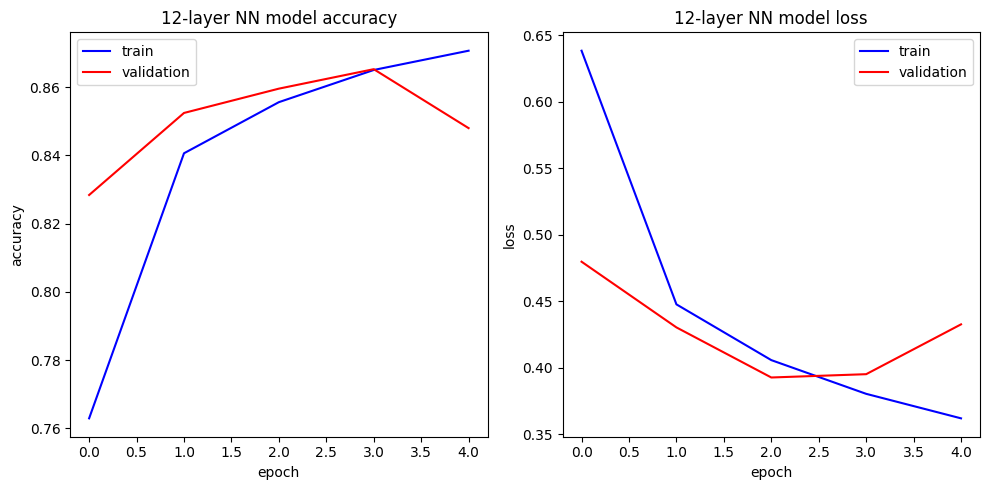

In [ ]:
# plot the learning curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_12NN.history['accuracy'], 'blue')
plt.plot(history_12NN.history['val_accuracy'], 'red')
plt.title('12-layer NN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_12NN.history['loss'], 'blue')
plt.plot(history_12NN.history['val_loss'], 'red')
plt.title('12-layer NN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')

plt.tight_layout()

In [ ]:
# evaluate the model on the test set
test_loss, test_acc = model_12.evaluate(X_test, y_test_OHE)
print('\n')
print('Model: 12-layer NN - test loss: ',round(test_loss*100,4),'%')
print('Model 12-layer NN - test accuracy: ',round(test_acc*100,4),'%')

313/313 [==============================] - 1s 4ms/step - loss: 0.4662 - accuracy: 0.8320


Model: 12-layer NN - test loss:  46.6205 %
Model 12-layer NN - test accuracy:  83.2 %


The 12-layer NN performs significantly worse than the previous 3-layer (accuracy: 86% - loss: 39%) and 6-layer NNs (accuracy: 87% - loss: 36%), thus so far the best performing model is the 6-layer NN.

Let's now move on to using a Convolutional NN to predict the Fashion-MNIST dataset and see if we can break over the 90% of accuracy.

#Convolutional Neural Network (CNN)

## Simple CNN

CNNs are widely used in image-related applications, such as image recognition. The typical architecture of CNNs differs from other NNs for the presence of convolutional and pooling layers:
- **convolutional** layer - it convolves an image by applying a numerical filter to it. The idea is to filter down sections of pixels into single values by computing the dot product of the filter and the image segment. Different filters are designed to identify different features.
![picture](https://miro.medium.com/v2/resize:fit:1400/1*D6iRfzDkz-sEzyjYoVZ73w.gif)

- **pooling** layer - it reduces the number of parameters in the next layer by grouping neighboring pixels into a single value. Once the convolutional layer has generated the image features, the pooling layer performs dimensionality reduction on them.
![picture](https://www.bouvet.no/bouvet-deler/understanding-convolutional-neural-networks-part-1/_/attachment/inline/e60e56a6-8bcd-4b61-880d-7c621e2cb1d5:6595a68471ed37621734130ca2cb7997a1502a2b/Pooling.gif)

In our CNN we will adopt a **2D Convo** because we are dealing with 2-dimensional data (28x28 images), **ReLu** activation function and start with a 3x3 filter size. We will also use the **padding** technique to avoid downsampling the edges and corners.

After the convolutional layer we will have a **max-pooling** layer of size 2x2: meaning that the image is divided into 2x2 partitions and the pooling filter retains only the maximum value of each partition.

We will also use **droput** and **batch normalization** layers: these are not structural layers of the network but improve the network performance. Dropout layers help to avoid overfitting by dropping out a percentage (0.2 so 20% in our case) of the neurons in that layer over each training epoch, in order to force the remaining nodes to compensate for their influence. Batch normalization layers normalize the activation output of the prior layer to have mean 0 and standard deviation 1, and empirically it will enhance the network performance.

Similarly to the MLP we will use a **Flatten layer** that converts the data into the appropriate format to be fed to the dense sequential layers of the network.
After flattening there will be a dense layer with 256 neurons and, as last layer of the network, we will have an output layer with 10 neurons (one for each class) and **softmax** activation function.

In [ ]:
# build the model
simple_CNN = keras.Sequential()
simple_CNN.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1))) 
simple_CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
simple_CNN.add(keras.layers.Dropout(0.2))
simple_CNN.add(keras.layers.Flatten())
simple_CNN.add(keras.layers.Dense(256, activation='relu'))
simple_CNN.add(keras.layers.BatchNormalization())
simple_CNN.add(keras.layers.Dropout(0.2))
simple_CNN.add(keras.layers.Dense(10, activation='softmax'))

# architecture of the model
simple_CNN.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 flatten_7 (Flatten)         (None, 6272)              0         
                                                                 
 dense_26 (Dense)            (None, 256)               1605888   
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                      

In [ ]:
# compile the model
simple_CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])

# train the model
history_simple_CNN = simple_CNN.fit(X_train, y_train_OHE, epochs=5, validation_split=0.33)

Epoch 1/5
1257/1257 [==============================] - 9s 6ms/step - loss: 0.4100 - accuracy: 0.8558 - val_loss: 0.3165 - val_accuracy: 0.8893
Epoch 2/5
1257/1257 [==============================] - 8s 7ms/step - loss: 0.3057 - accuracy: 0.8900 - val_loss: 0.2816 - val_accuracy: 0.8972
Epoch 3/5
1257/1257 [==============================] - 8s 6ms/step - loss: 0.2675 - accuracy: 0.9020 - val_loss: 0.2731 - val_accuracy: 0.9006
Epoch 4/5
1257/1257 [==============================] - 8s 7ms/step - loss: 0.2447 - accuracy: 0.9092 - val_loss: 0.2706 - val_accuracy: 0.9024
Epoch 5/5
1257/1257 [==============================] - 7s 5ms/step - loss: 0.2213 - accuracy: 0.9178 - val_loss: 0.2544 - val_accuracy: 0.9100


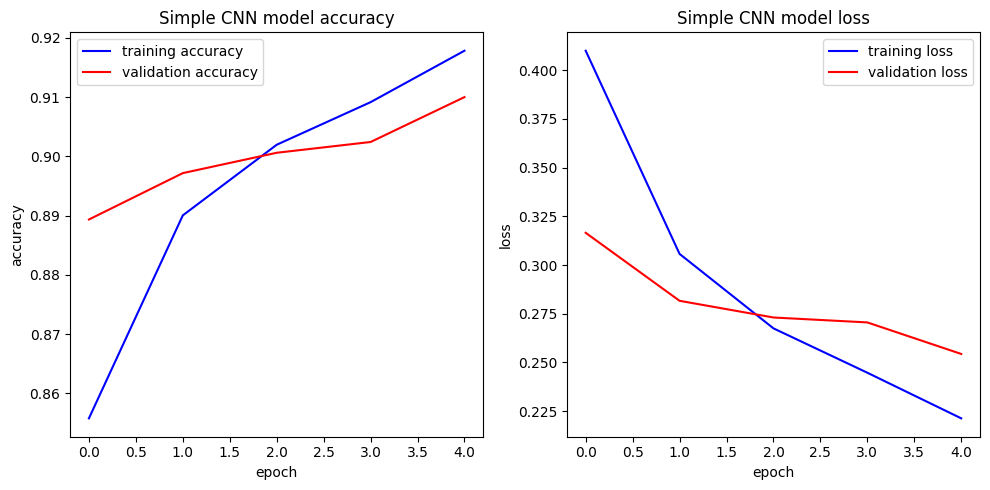

In [ ]:
# plot the learning curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_simple_CNN.history['accuracy'], 'blue')
plt.plot(history_simple_CNN.history['val_accuracy'], 'red')
plt.title('Simple CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_simple_CNN.history['loss'], 'blue')
plt.plot(history_simple_CNN.history['val_loss'], 'red')
plt.title('Simple CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss','validation loss'], loc='upper right')

plt.tight_layout()

In [ ]:
# evaluate the model on the test set
test_loss, test_acc = simple_CNN.evaluate(X_test, y_test_OHE)
print('\n')
print('Model: simple CNN - test loss: ',round(test_loss*100,4),'%')
print('Model: simple CNN - test accuracy: ',round(test_acc*100,4),'%')

313/313 [==============================] - 1s 3ms/step - loss: 0.2712 - accuracy: 0.9056


Model: simple CNN - test loss:  27.1182 %
Model: simple CNN - test accuracy:  90.56 %


A fairly simple CNN with only one convolutional layer and pooling layer achieved 90% of accuracy and also the test loss significantly improved with respect to the previous ANNs.

313/313 [==============================] - 1s 2ms/step


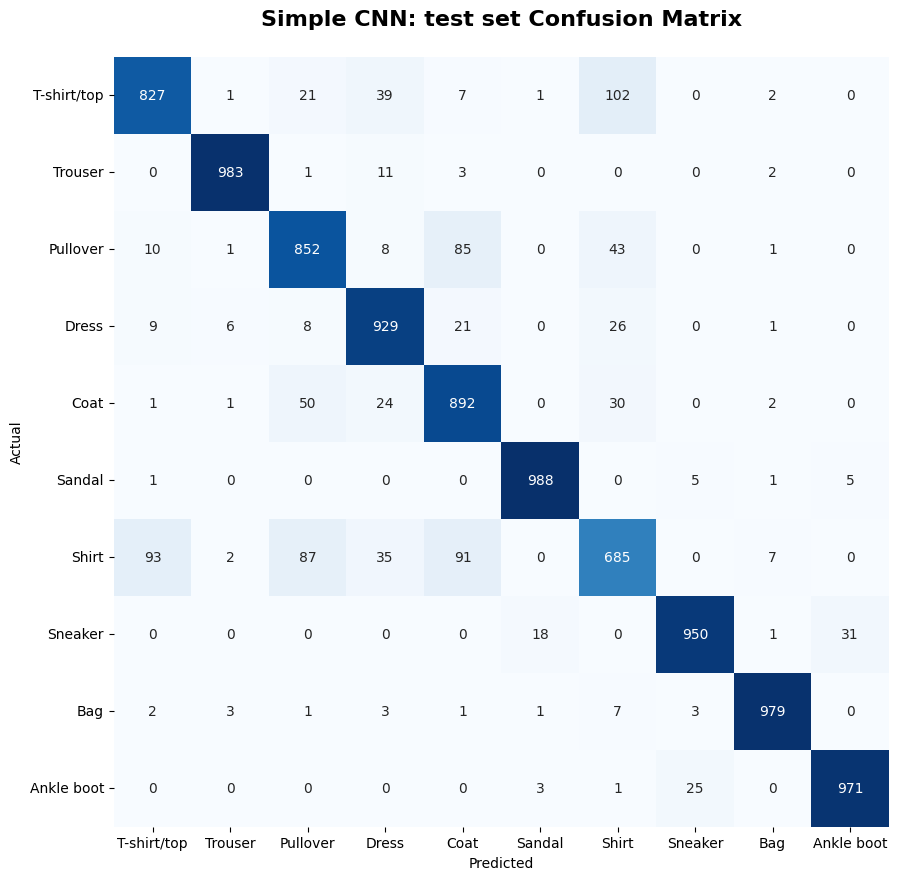

In [ ]:
# predict the test set and compare the predictions with the real classes
y_pred = simple_CNN.predict(X_test)              # predict test set
y_pred_CM = np.argmax(y_pred, axis=1)            # get the index of the max value in the prediction vector (so the most probable class) for each example predicted
y_test_CM = np.argmax(y_test_OHE, axis=1)        # get the index of the max value in the encoded vector with the real classes for each example

# compute and diplay the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test_CM, y_pred_CM), annot=True, cbar=False, fmt='1d', cmap='Blues', ax=ax)
ax.set_title('Simple CNN: test set Confusion Matrix\n', fontweight='bold', fontsize=16)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names, rotation=0)
plt.show()

Once again, the examples belonging to the *Shirt* class are most often misclassified as other items in the shape of a top. Also footwear items are sometimes mistaken for each other.

Let's now try a more advanced CNN that combines more layers.

## Advanced CNN

Let's now see the image classification performance of a more structured CNN that combines 4 convolutional layers, max-pooling layers, BatchNormalization and 20% dropout.

For this attempt we will also use **ModelCheckpoint** with **save_best_only** parameter to save the best end-of-epoch model. This checkpoint strategy allows to save the model that during training has achieved the best performance, using validation accuracy as metrics.


In [ ]:
# build the model
adv_CNN = keras.Sequential()

adv_CNN.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1))) 
adv_CNN.add(keras.layers.BatchNormalization())
adv_CNN.add(keras.layers.Dropout(0.2))

adv_CNN.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')) 
adv_CNN.add(keras.layers.Dropout(0.2))

adv_CNN.add(keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')) 
adv_CNN.add(keras.layers.Dropout(0.2))

adv_CNN.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')) 
adv_CNN.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
adv_CNN.add(keras.layers.Dropout(0.2))

adv_CNN.add(keras.layers.Flatten())
adv_CNN.add(keras.layers.Dense(128, activation='relu'))
adv_CNN.add(keras.layers.Dropout(0.3))
adv_CNN.add(keras.layers.Dense(10, activation='softmax'))

# architecture of the model
adv_CNN.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_18 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_19 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 24)        6936      
                                                      

In [ ]:
# compile the model
adv_CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])

# ModelCheckpoint allows us to extract the best end-of-epoch model
callback_list = [ModelCheckpoint(filepath='cnn.h5', monitor='val_accuracy', save_best_only=True, mode='max')]

# train the model
history_adv_CNN = adv_CNN.fit(X_train, y_train_OHE, epochs=5, validation_split=0.33, callbacks=callback_list)

Epoch 1/5
1257/1257 [==============================] - 16s 10ms/step - loss: 0.5610 - accuracy: 0.8042 - val_loss: 0.3420 - val_accuracy: 0.8840
Epoch 2/5
1257/1257 [==============================] - 11s 9ms/step - loss: 0.3561 - accuracy: 0.8727 - val_loss: 0.2821 - val_accuracy: 0.8959
Epoch 3/5
1257/1257 [==============================] - 11s 9ms/step - loss: 0.3117 - accuracy: 0.8867 - val_loss: 0.2409 - val_accuracy: 0.9101
Epoch 4/5
1257/1257 [==============================] - 11s 9ms/step - loss: 0.2792 - accuracy: 0.8979 - val_loss: 0.2408 - val_accuracy: 0.9127
Epoch 5/5
1257/1257 [==============================] - 11s 9ms/step - loss: 0.2574 - accuracy: 0.9045 - val_loss: 0.2338 - val_accuracy: 0.9161


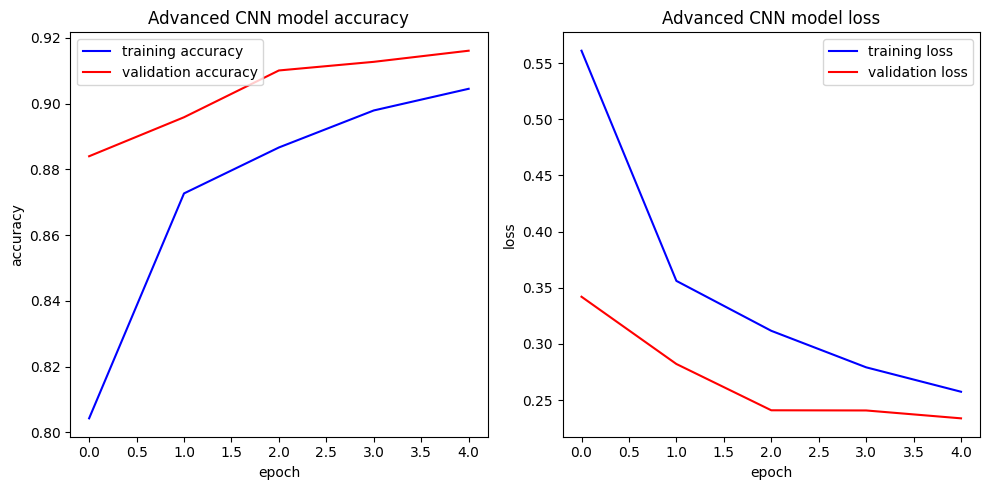

In [ ]:
# plot the learning curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_adv_CNN.history['accuracy'], 'blue')
plt.plot(history_adv_CNN.history['val_accuracy'], 'red')
plt.title('Advanced CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_adv_CNN.history['loss'], 'blue')
plt.plot(history_adv_CNN.history['val_loss'], 'red')
plt.title('Advanced CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss','validation loss'], loc='upper right')

plt.tight_layout()

In [ ]:
# load in the best model state from ModelCheckpoint
cnn_best = load_model('cnn.h5')

# evaluate the model on the test set
test_loss, test_acc = cnn_best.evaluate(X_test, y_test_OHE)
print('\n')
print('Model: advanced CNN - test loss: ',round(test_loss*100,4),'%')
print('Model: advanced CNN - test accuracy: ',round(test_acc*100,4),'%')

313/313 [==============================] - 1s 3ms/step - loss: 0.2479 - accuracy: 0.9102


Model: advanced CNN - test loss:  24.7853 %
Model: advanced CNN - test accuracy:  91.02 %


Compared to the simple CNN (test loss: 27.1% and test accuracy: 90.5%), the advanced CNN performs better when trained with the same number of epochs (5). The advanced CNN achieved only a slightly higher test accuracy (91.0%) than the simple CNN; but test loss has improved a lot, since it has decreased below 25%.

313/313 [==============================] - 1s 2ms/step


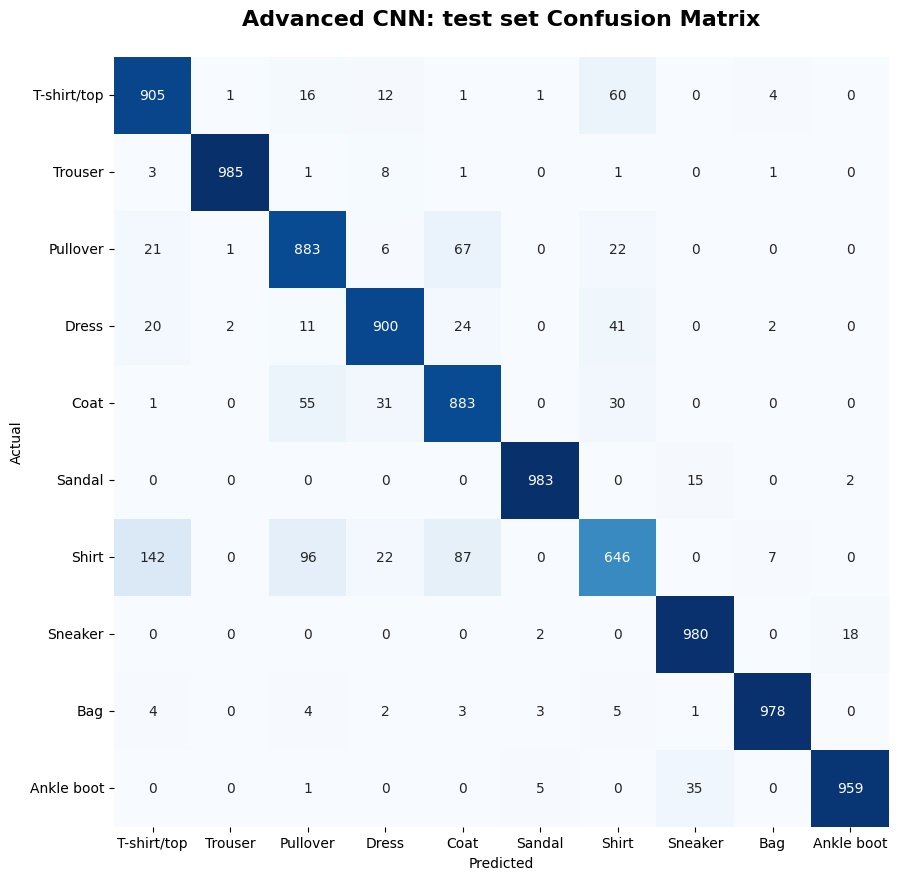

In [ ]:
# predict the test set and compare the predictions with the real classes
y_pred = cnn_best.predict(X_test)                # predict test set
y_pred_CM = np.argmax(y_pred, axis=1)            # get the index of the max value in the prediction vector (so the most probable class) for each example predicted
y_test_CM = np.argmax(y_test_OHE, axis=1)        # get the index of the max value in the encoded vector with the real classes for each example

# compute and diplay the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test_CM, y_pred_CM), annot=True, cbar=False, fmt='1d', cmap='Blues', ax=ax)
ax.set_title('Advanced CNN: test set Confusion Matrix\n', fontweight='bold', fontsize=16)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names, rotation=0)
plt.show()

The advanced CNN makes the same types of mistakes as the simple CNN: examples in the shape of a top (*T-shirt/top*, *Pullover*, *Dress*, *Coat*, *Shirt*) are sometimes confused for each other. Also footwear (*Sandal*, *Sneaker*, *Ankle boot*) are occasionally mistaken for each other, but are almost never confused with other types of outwear.

# Conclusions

We compared 3 types of multilayer perceptrons (MLP: 3-layer NN, 6-layer NN, 12-layer NN) with different Convolutional NN architectures (simple CNN, advanced CNN) and concluded that even the simplest CNN easily breaks over the 90% of accuracy on the test set: thus defeating the best-performing MLP, that does not exceed the 87% test accuracy. 
Among the CNN, the advanced model achieved the best results, with 91.0% test accuracy and 24.7% test loss. 

Looking at the confusion matrices generated by the different models, we noticed that some categories cause more errors than others. The classes *Shirt*, *T-shirt/top*, *Pullover*, *Dress*, *Coat* - basically the items in the shape of a top - cause the majority of the mistakes. Also the classes relating to footwear - *Sandal*, *Sneaker* and *Ankle boot* - are often mistaken for each other. 

These results are encouraging and indicate that the convolutional layers focused on meaningful features, such that classes with similar shape features are occasionally confused, while more distinct categories are almost never mistaken for each other.

Based on the errors that most of the models previously compared made, an interesting idea to improve the image classification performance on the Fashion-MNIST dataset, is to combine multiple NNs into a hierarchy. For instance, a first NN is used to classify the examples into 4 generic categories: tops, trousers, bag and footwear. Then, two separate NNs are used to discriminate between the finer classes within the *top* category (*T-shirt/top*, *Pullover*, *Dress*, *Coat*, *Shirt*) and the *footwear* category (*Sandal*, *Sneaker*, *Ankle boot*). A similar architecture could be able to achieve greater success in the labelling task of the Fashion-MNIST examples; with respect to the hereby proposed models, that carry out image classification into 10 classes all at once.